<a href="https://colab.research.google.com/github/boangri/uai-thesis-notebooks/blob/main/notebooks/GrandPrix_reinforce_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GrandPrix - Monte Carlo Policy Gradient  

In [ ]:
!pip install -e git+https://github.com/boangri/gym-grand-prix.git#egg=gym_grand_prix

Obtaining gym_grand_prix from git+https://github.com/boangri/gym-grand-prix.git#egg=gym_grand_prix
  Cloning https://github.com/boangri/gym-grand-prix.git to ./src/gym-grand-prix
  Running command git clone -q https://github.com/boangri/gym-grand-prix.git /content/src/gym-grand-prix
     |████████████████████████████████| 11.5MB 7.8MB/s 
  Running setup.py develop for gym-grand-prix


In [6]:
%tensorflow_version 1.x
from keras.layers import Dense, Activation, Input
from keras.models import Model, load_model
from keras.optimizers import Adam, RMSprop
import keras.backend as K
import numpy as np

from keras import __version__
print(__version__)
from tensorflow import __version__
print(__version__)


2.3.1
1.15.2


## Agent 

In [ ]:
FNAME = 'grandprix.h5'
class Agent(object):
    def __init__(self, ALPHA, GAMMA=0.80, n_actions=5, n_rays=5,
                 layer1_size=64, layer2_size=64,
                 fname=FNAME):
        self.gamma = GAMMA
        self.lr = ALPHA
        self.G = 0
        self.input_dims = 2 + n_rays
        self.fc1_dims = layer1_size
        self.fc2_dims = layer2_size
        self.n_actions = n_actions
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []

        self.policy, self.predict = self.build_policy_network()
        self.action_space = [i for i in range(n_actions)]
        self.model_file = fname
        self.norm = np.array((1., 1.)+(0.25,)*n_rays)

    def build_policy_network(self):
        input = Input(shape=(self.input_dims,))
        advantages = Input(shape=[1])
        dense1 = Dense(self.fc1_dims, activation='relu')(input)
        dense2 = Dense(self.fc2_dims, activation='relu')(dense1)
        probs = Dense(self.n_actions, activation='softmax')(dense2)

        def custom_loss(y_true, y_pred):
            out = K.clip(y_pred, 1e-8, 1 - 1e-8)
            log_lik = y_true * K.log(out)

            return K.sum(-log_lik * advantages)

        policy = Model(inputs=[input, advantages], outputs=[probs])
        policy.compile(optimizer=RMSprop(lr=self.lr), loss=custom_loss)

        predict = Model(inputs=[input], outputs=[probs])

        return policy, predict

    def choose_action(self, observation):
        state = observation[np.newaxis, :]
        state *= self.norm
        probabilities = self.predict.predict(state)[0]
        action = np.random.choice(self.action_space, p=probabilities)

        return action

    def store_transition(self, observation, action, reward):
        self.action_memory.append(action)
        self.state_memory.append(observation)
        self.reward_memory.append(reward)

    def learn(self):
        state_memory = np.array(self.state_memory)
        action_memory = np.array(self.action_memory)
        reward_memory = np.array(self.reward_memory)

        actions = np.zeros([len(action_memory), self.n_actions])
        actions[np.arange(len(action_memory)), action_memory] = 1

        G = np.zeros_like(reward_memory)
        for t in range(len(reward_memory)):
            G_sum = 0.
            discount = 1.
            for k in range(t, len(reward_memory)):
                G_sum += reward_memory[k] * discount
                discount *= self.gamma

            G[t] = G_sum
        mean = np.mean(G)
        std = np.std(G) if np.std(G) > 0 else 1.
        self.G = (G - mean) / std

        cost = self.policy.train_on_batch([state_memory, self.G], actions)

        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []

    # return cost

    def save_model(self, fname=FNAME):
        self.predict.save(fname)

    def load_model(self,  fname=FNAME):
        self.predict = load_model(fname)

    def save_weights(self, fname='weights.h5'):
        self.predict.save_weights(fname)

    def load_weights(self,  fname='weights.h5'):
        self.predict.load_weights(fname)
    
print("Agent GrandPrix v0.0.6 30.10.2020")

Agent GrandPrix v0.0.6 30.10.2020


## Обучение


In [ ]:
import gym
import gym_grand_prix

import numpy as np
import random

from time import time
import matplotlib.pyplot as plt

def plot(score_history, filename='learning.png', title='Training'):
    x = [i+1 for i in range(len(score_history))]
    avg_score = []
    for i in range(len(score_history)):
        avg_score.append(np.mean(score_history[i-100:i])) 

    fig = plt.figure(figsize=(12, 6))
    plt.scatter(x, score_history, label='score')
    plt.plot(x, avg_score, color='C1', label='avg_score')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()
    plt.ylim(-8)
    plt.grid()
    plt.show()
    fig.savefig(filename)

In [ ]:
n_rays = 5
GAMMA = 0.95
fc1 = 512
fc2 = 128
ind = int((n_rays + 3)/2) # Индекс луча, смотрящего вперед (расстояние до стенки)
agent = Agent(ALPHA=0.0005, GAMMA=GAMMA, n_actions=5, n_rays=n_rays,
                layer1_size=fc1, layer2_size=fc2)

resume_learn = False
render = False
if resume_learn:
    agent.load_weights()
    print("Loaded model weights")

score_history = []
collision_history = []
running_score = 0.
running_collisions = 0.
record_score = 0.
record_avg_score = 0.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


pygame 2.0.0 (SDL 2.0.12, python 3.6.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
0,-4.8821,-4.8821,-4.8821,3,4,4.00
1,-7.7485,-6.3153,-6.3153,3,7,5.50
2,-4.9043,-5.8450,-5.8450,3,4,5.00
3,-4.9183,-5.6133,-5.6133,3,3,4.50
4,-4.4759,-5.3858,-5.3858,3,4,4.40
5,-3.1582,-5.0145,-5.0145,3,4,4.33
6,-7.6035,-5.3844,-5.3844,3,7,4.71
7,-8.6721,-5.7954,-5.7954,3,8,5.13
8,-3.9623,-5.5917,-5.5917,3,3,4.89
9,-4.3160,-5.4641,-5.4641,3,4,4.80
10,-7.6195,-5.6600,-5.6600,3,7,5.00
11,-4.1764,-5.5364,-5.5364,3,2,4.75
12,-1.2634,-5.2077,-5.2077,3,1,4.46
13,-2.5186,-5.0156,-5.0156,3,2,4.29
14,-3.4842,-4.9135,-4.9135,3,3,4.20
15,-3.2046,-4.8067,-4.8067,3,2,4.06
16,-1.8918,-4.6353,-4.6353,3,1,3.88
17,-2.7399,-4.5300,-4.5300,3,2,3.78
18,-3.8220,-4.4927,-4.4927,3,3,3.74
19,-1.1957,-4.3279,-4.3279,3,0,3.55
20,-3.5754,-4.2920,-4.2920,3,3,3.52
21,-0.8124,-4.1339,-4.1339,3,0,3.36
22,-3.5237,-4.1073,-4.1073,3,3,3.35
23,-1.6995,-4.0070,-4.0070,3,0,3.21
24,-1.5079,-3.9070,-3.9070,3,1,3.12
25,-0.2696,-3.7

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


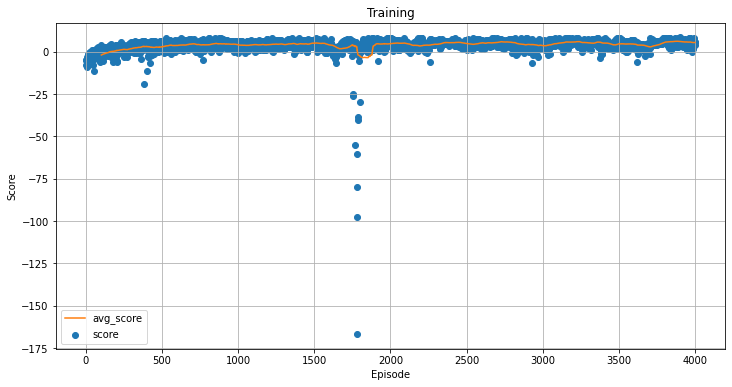

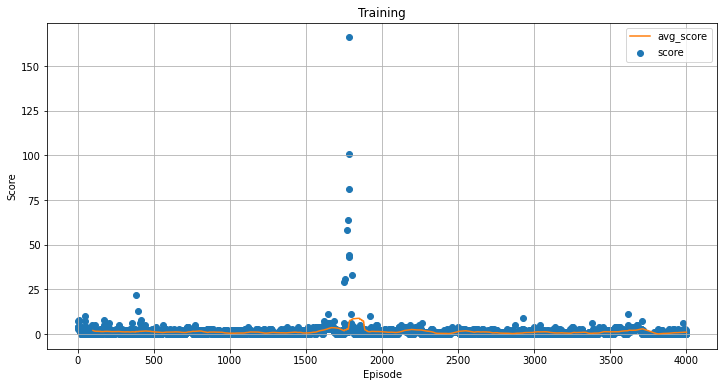

In [ ]:
ep0 = 0 # номер начального эпизода (для обучения в несколько этапов)
n_episodes = 4000
n_steps = 200 # число шагов в эпизоде
fname = "%dx%d_ep%dg%2d" % (fc1, fc2, n_episodes, int(GAMMA*100))
possible_actions = ((0, 0), (1, .75), (-1, .75), (0, .75), (0, -.75))
random.seed(ep0+12345)
track = 3
env = gym.make('GrandPrix-v0')
options = {
    'nrays': n_rays,
    'seed': track, # задает номер трека
}
if render:
    options['display'] = 1
    env.setOptions(options)
    
cur_time = time()

for i in range(ep0, n_episodes):
    score = 0
    observation = env.reset()
    collisions = 0
    for step in range(n_steps):
        if render:
            env.render()
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(possible_actions[action])
        if 'collision' in info and info['collision']:
            collisions += 1
            reward -= 200.
        score += reward
        agent.store_transition(observation, action, reward)
        observation = observation_
        
    score /= n_steps
    score_history.append(score)
    collision_history.append(collisions)
    beta = 1/(1 + min(99, i))
    running_score = (1 - beta)*running_score + beta*score
    running_collisions = (1 - beta)*running_collisions + beta*collisions
    # fixing records
    if score > record_score:
        record_score = score
        record_score_ep = i
        agent.save_weights('record_score.h5')
    if running_score > record_avg_score:
        record_avg_score = running_score
        record_avg_score_ep = i
        agent.save_weights('record_avg_score.h5')
    agent.learn()
    print("%d,%.3f,%.3f,%.3f,%d,%.3f" 
            % (i, score, np.mean(score_history[-100:]), running_score, collisions, running_collisions))

print("It took %.1f secs" % (time() - cur_time))
print("Record score %.3f at episode %d" % (record_score, record_score_ep))
print("Record avg score %.3f at episode %d" % (record_avg_score, record_avg_score_ep))
filename = fname + '.png'
agent.save_weights(fname + '.h5')
plot(score_history, filename=filename)
plot(collision_history, filename='collisions.png')

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


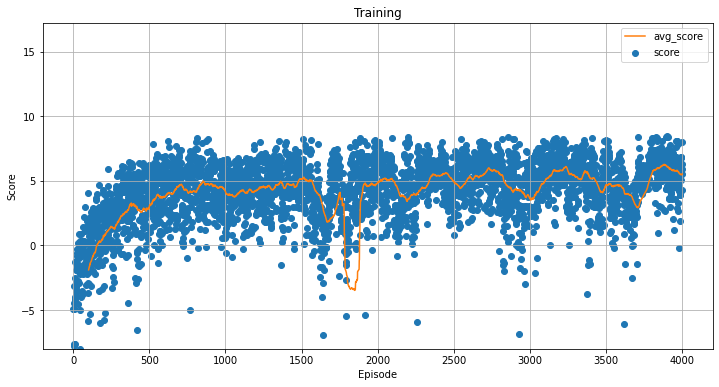

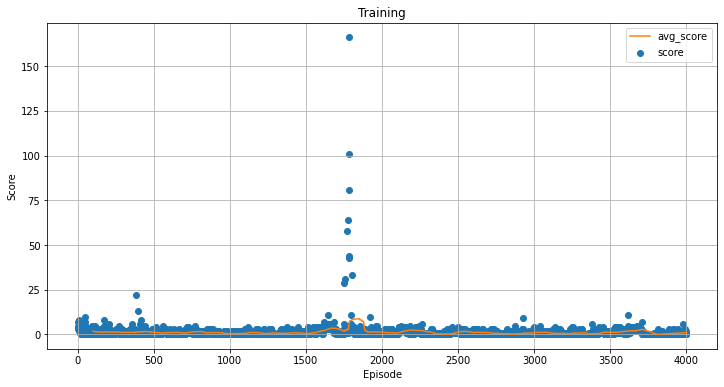

In [ ]:
plot(score_history, filename=filename)
plot(collision_history, filename='collisions.png')

In [ ]:
gdir = '/content/drive/My Drive/Models/'

In [ ]:
!ls -l '/content/drive/My Drive/Models/'


total 1652864
-rw------- 1 root root   2769504 Sep 24 15:37  best_model_base.h5
-rw------- 1 root root   2769536 Sep 24 17:45  best_model_face0.h5
-rw------- 1 root root  71643896 Sep 24 17:57  best_model_face1.h5
-rw------- 1 root root  16467824 Sep 24 18:31  best_model_face2.h5
-rw------- 1 root root   4060144 Sep 24 18:48  best_model_face3.h5
-rw------- 1 root root   2769240 Sep 27 20:50  best_model_face.h5
-rw------- 1 root root   4373048 Sep 22 18:35  best_model_fashion.h5
-rw------- 1 root root  41162664 Sep 25 18:07  best_model_paint12.h5
-rw------- 1 root root  41162176 Sep 25 15:31  best_model_paint14.h5
-rw------- 1 root root  41162664 Sep 25 18:45  best_model_paint15.h5
-rw------- 1 root root  41169088 Sep 25 09:31  best_model_paint16.h5
-rw------- 1 root root  41169088 Sep 23 19:46  best_model_paint.h5
-rw------- 1 root root  41183400 Sep 24 06:47  best_model_quad.h5
-rw------- 1 root root  75583520 Oct 13 17:08  best_pspnet.h5
-rw------- 1 root root 117704008 Oct 14 15:43 

In [ ]:
import shutil
shutil.copy2(fname + '.h5', gdir)


'/content/drive/My Drive/Models/512x128_ep4000g95.h5'

In [1]:
keras.__version__

NameError: ignored